# AJ_0065.7 - SCENIC 5x interpretation

### The aim here is to import the AUC matrix and regulons data and try to answer some of the following questions  

**Runs with R_scRNAseq env**

1) What are the most active regulons per cluster (previously defined clusters in seurat)  
2) What are the cluster specific regulons  
  
  
But also to visualize the regulons activity  
1) Plot tSNEs for all the regulons, 1 Regulon/1 tSNE  
2) Heatmap organized per cluster and per pseudotime

In [2]:
library(dplyr)
library(Seurat)
library(readr)
library(SingleCellExperiment, quietly = TRUE)
library(scater, quietly = TRUE)
library(tidyr)
library(purrr)
library(cowplot)
library(ggrepel)
library(viridis)
library(ggdendro)
library(gridExtra)
library(egg)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'Seurat' was built under R version 3.6.2"Registered S3 method overwritten by 'R.oo':
  method        from       
  throw.default R.methodsS3
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from 'package:dplyr':

    combine, intersect, setdiff, union

The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs

The following objects are masked from 'pac

In [3]:
setwd("/staging/leuven/stg_00041/Adrian/TALON_JANISZEWSKI_XCR2/")

### Importing the pySCENIC output, reduced dims from seurat and clusters annotation

Import pySCENIC output

In [4]:
auc_mtx <- read.csv("SCENIC/auc_mtx_5.csv")

In [5]:
head(auc_mtx)

Cell,X2410141K09Rik...,Akr1a1...,Alx1...,Alx3...,Alx4...,Arid3a...,Arnt...,Atf3...,Atf4...,...,Zfp148...,Zfp362...,Zfp410...,Zfp42...,Zfp467...,Zfp667...,Zic3...,Zic5...,Zmiz1...,Zscan10...
Day_9_Xi_Mus_33,0.04189857,0.1412515,0,0,0,0.17659295,0.00000000,0.07668644,0.09558015,...,0.00000000,0,0.0000000,0.06540736,0.07630722,0.04782211,0.0000000,0,0.075012198,0.08569761
Day_10_Xi_Mus_25,0.17300972,0.1295921,0,0,0,0.05630640,0.08029930,0.02993759,0.16795411,...,0.01319862,0,0.0000000,0.11827622,0.00000000,0.11238005,0.0000000,0,0.007973111,0.15575260
Day_10_Xi_Mus_32,0.10660650,0.1295921,0,0,0,0.10619694,0.06599512,0.05396919,0.18447566,...,0.00000000,0,0.0000000,0.08585769,0.00000000,0.12837342,0.0000000,0,0.031736208,0.12836103
Day_9_Xi_Mus_27,0.11266982,0.1293932,0,0,0,0.13793736,0.03021848,0.07551412,0.14347473,...,0.03371463,0,0.0000000,0.09190361,0.00000000,0.03700477,0.0000000,0,0.039008209,0.11342516
Day_9_Xi_Mus_36,0.13542941,0.1290948,0,0,0,0.11177643,0.00000000,0.04981346,0.12447627,...,0.00000000,0,0.1712373,0.08658987,0.07376799,0.06449128,0.0000000,0,0.023464786,0.16054179
Day_10_Xi_Mus_30,0.24870989,0.1293932,0,0,0,0.02614772,0.00000000,0.03021372,0.15539862,...,0.02900200,0,0.0000000,0.18275565,0.05202173,0.08431324,0.1364037,0,0.009582028,0.21361607


In [6]:
dim(auc_mtx)

[1] 567 312

Import reduced dimensions from Seurat tSNE 

In [7]:
red_dims <- read.csv("SCENIC/resources_folder/AJ_0065_tSNE_dims.csv")
colnames(red_dims)[1] <- "Cell"

In [8]:
head(red_dims)

Cell,tSNE_1,tSNE_2,Timepoint
Day_9_Xi_Mus_33,-9.225725,-7.4343086,Day_9
Day_10_Xi_Mus_25,-9.906587,7.9507435,Day_10
Day_10_Xi_Mus_32,-10.664682,0.2424442,Day_10
Day_9_Xi_Mus_27,-9.670420,-5.1948308,Day_9
Day_9_Xi_Mus_36,-8.247826,-0.1422239,Day_9
Day_10_Xi_Mus_30,8.634478,7.8346926,Day_10


Import clusters annotation

In [9]:
seurat <- readRDS("seurat/seurat_clustering.rds")

In [10]:
seurat

An object of class Seurat 
26127 features across 567 samples within 1 assay 
Active assay: RNA (26127 features)
 2 dimensional reductions calculated: pca, tsne

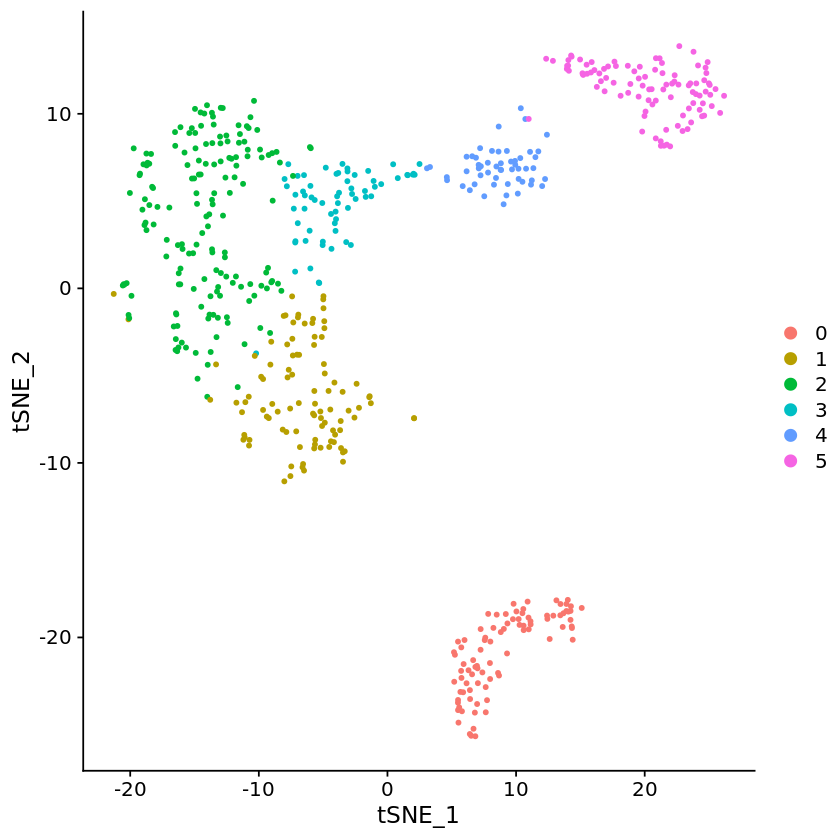

In [11]:
DimPlot(seurat, reduction = "tsne")

In [12]:
Cell <- seurat@meta.data$Name
clusters <- seurat@meta.data$seurat_clusters_rename
clusters <- data.frame(Cell, clusters)

### Join the data

In [17]:
regulon_anno <- left_join(auc_mtx, red_dims, by = "Cell")
regulon_anno <- left_join(regulon_anno, clusters, by = "Cell")

In [18]:
head(regulon_anno)

Cell,X2410141K09Rik...,Akr1a1...,Alx1...,Alx3...,Alx4...,Arid3a...,Arnt...,Atf3...,Atf4...,...,Zfp467...,Zfp667...,Zic3...,Zic5...,Zmiz1...,Zscan10...,tSNE_1,tSNE_2,Timepoint,clusters
Day_9_Xi_Mus_33,0.04189857,0.1412515,0,0,0,0.17659295,0.00000000,0.07668644,0.09558015,...,0.07630722,0.04782211,0.0000000,0,0.075012198,0.08569761,-9.225725,-7.4343086,Day_9,1
Day_10_Xi_Mus_25,0.17300972,0.1295921,0,0,0,0.05630640,0.08029930,0.02993759,0.16795411,...,0.00000000,0.11238005,0.0000000,0,0.007973111,0.15575260,-9.906587,7.9507435,Day_10,2
Day_10_Xi_Mus_32,0.10660650,0.1295921,0,0,0,0.10619694,0.06599512,0.05396919,0.18447566,...,0.00000000,0.12837342,0.0000000,0,0.031736208,0.12836103,-10.664682,0.2424442,Day_10,2
Day_9_Xi_Mus_27,0.11266982,0.1293932,0,0,0,0.13793736,0.03021848,0.07551412,0.14347473,...,0.00000000,0.03700477,0.0000000,0,0.039008209,0.11342516,-9.670420,-5.1948308,Day_9,1
Day_9_Xi_Mus_36,0.13542941,0.1290948,0,0,0,0.11177643,0.00000000,0.04981346,0.12447627,...,0.07376799,0.06449128,0.0000000,0,0.023464786,0.16054179,-8.247826,-0.1422239,Day_9,2
Day_10_Xi_Mus_30,0.24870989,0.1293932,0,0,0,0.02614772,0.00000000,0.03021372,0.15539862,...,0.05202173,0.08431324,0.1364037,0,0.009582028,0.21361607,8.634478,7.8346926,Day_10,4


In [22]:
regulon_anno_long <- gather(regulon_anno, regulon, activity, -Timepoint, -clusters, -Cell, -tSNE_1, -tSNE_2)

In [23]:
head(regulon_anno_long)
dim(regulon_anno_long)

Cell,tSNE_1,tSNE_2,Timepoint,clusters,regulon,activity
Day_9_Xi_Mus_33,-9.225725,-7.4343086,Day_9,1,X2410141K09Rik...,0.04189857
Day_10_Xi_Mus_25,-9.906587,7.9507435,Day_10,2,X2410141K09Rik...,0.17300972
Day_10_Xi_Mus_32,-10.664682,0.2424442,Day_10,2,X2410141K09Rik...,0.10660650
Day_9_Xi_Mus_27,-9.670420,-5.1948308,Day_9,1,X2410141K09Rik...,0.11266982
Day_9_Xi_Mus_36,-8.247826,-0.1422239,Day_9,2,X2410141K09Rik...,0.13542941
Day_10_Xi_Mus_30,8.634478,7.8346926,Day_10,4,X2410141K09Rik...,0.24870989


[1] 176337      7

In [24]:
regulon_anno_long$regulon <- gsub('.{0,3}$', '', regulon_anno_long$regulon) # Remove 3 dots at the end of regulon's name
head(regulon_anno_long)

Cell,tSNE_1,tSNE_2,Timepoint,clusters,regulon,activity
Day_9_Xi_Mus_33,-9.225725,-7.4343086,Day_9,1,X2410141K09Rik,0.04189857
Day_10_Xi_Mus_25,-9.906587,7.9507435,Day_10,2,X2410141K09Rik,0.17300972
Day_10_Xi_Mus_32,-10.664682,0.2424442,Day_10,2,X2410141K09Rik,0.10660650
Day_9_Xi_Mus_27,-9.670420,-5.1948308,Day_9,1,X2410141K09Rik,0.11266982
Day_9_Xi_Mus_36,-8.247826,-0.1422239,Day_9,2,X2410141K09Rik,0.13542941
Day_10_Xi_Mus_30,8.634478,7.8346926,Day_10,4,X2410141K09Rik,0.24870989


In [26]:
# Calculate mean regulon activity per cluster or timepoint
regulon_anno_long %>% group_by(regulon, Timepoint) %>% summarize(mean_activity = mean(activity), n_cells = n()) %>% write.csv(., "SCENIC/mean_reg_activity_per_timepoint.csv")
regulon_anno_long %>% group_by(regulon, clusters) %>% summarize(mean_activity = mean(activity), n_cells = n()) %>% write.csv(., "SCENIC/mean_reg_activity_per_cluster.csv")

### Plot individual regulons on tSNE

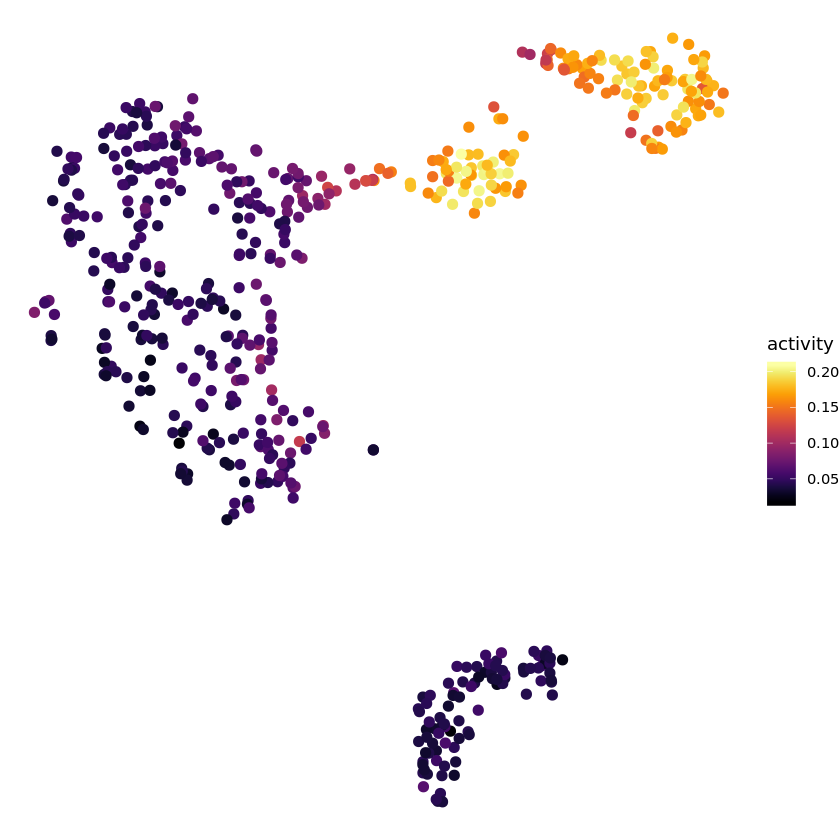

In [27]:
tSNE_regulon <- regulon_anno_long %>% 
              #group_split(regulon) %>% 
                dplyr::filter(regulon == "Rest") %>%
                ggplot(., aes(tSNE_1, tSNE_2, color = activity)) + 
                  geom_point(size = 2.5) +
                  scale_color_viridis(option = "B")+
                        theme_void()
tSNE_regulon

In [92]:
pdf("SCENIC/tSNE_regulon_Rest.pdf", useDingbats = FALSE)
plot(tSNE_regulon)
dev.off()

png 
  2

## Plot all regulons individually, each on a separate tSNE

## Define the most active regulons per each cluster

In [28]:
head(regulon_anno_long)

Cell,tSNE_1,tSNE_2,Timepoint,clusters,regulon,activity
Day_9_Xi_Mus_33,-9.225725,-7.4343086,Day_9,1,X2410141K09Rik,0.04189857
Day_10_Xi_Mus_25,-9.906587,7.9507435,Day_10,2,X2410141K09Rik,0.17300972
Day_10_Xi_Mus_32,-10.664682,0.2424442,Day_10,2,X2410141K09Rik,0.10660650
Day_9_Xi_Mus_27,-9.670420,-5.1948308,Day_9,1,X2410141K09Rik,0.11266982
Day_9_Xi_Mus_36,-8.247826,-0.1422239,Day_9,2,X2410141K09Rik,0.13542941
Day_10_Xi_Mus_30,8.634478,7.8346926,Day_10,4,X2410141K09Rik,0.24870989


Group the cells by cluster and compute mean regulon activity across the cluster

In [30]:
meanRegPerCluster <- regulon_anno_long %>%
                        select(-c(Cell, tSNE_1, tSNE_2, Timepoint)) %>%
                        group_by(clusters, regulon) %>%
                        summarize(mean_activity = mean(activity))

In [31]:
head(meanRegPerCluster)

clusters,regulon,mean_activity
0,Akr1a1,0.639520852
0,Alx1,0.021161321
0,Alx3,0.005356338
0,Alx4,0.001478155
0,Arid3a,0.031457827
0,Arnt,0.010600370


#### Highlight regulons that rank > 95th percentile.

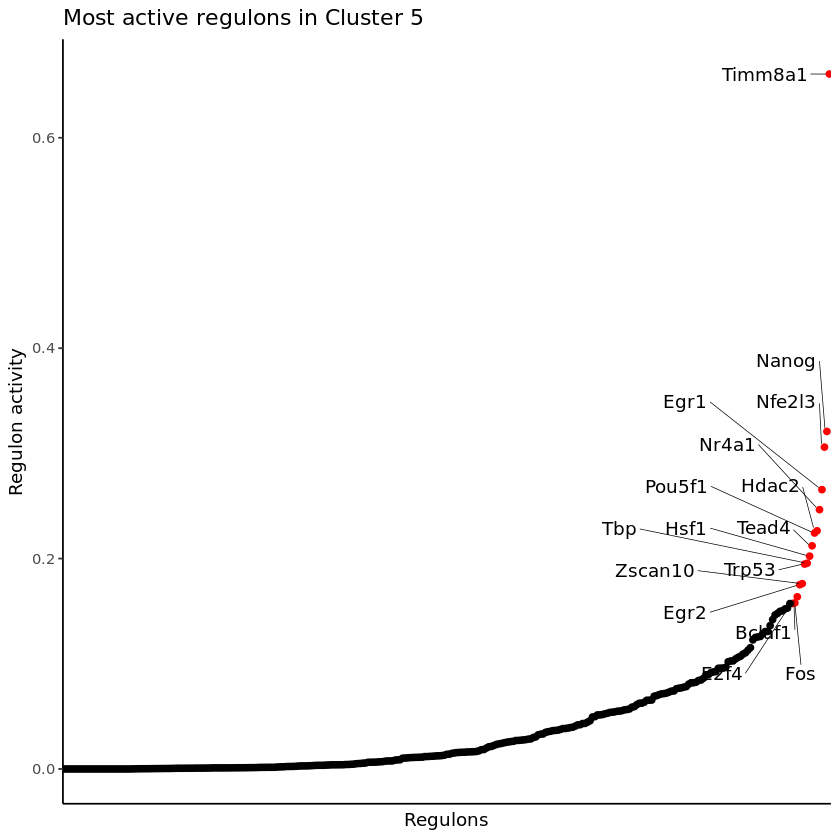

In [32]:
c0 <- meanRegPerCluster %>% 
            ungroup()%>%
            dplyr::filter(clusters == 3)
c0$regulon <- factor(c0$regulon, levels = c0$regulon[order(c0$mean_activity)])

ggplot(c0, aes(x= regulon, y = mean_activity)) +
       geom_point(color = ifelse(c0$mean_activity > quantile(c0$mean_activity, 0.95, names = FALSE), "red", "black")) +
        theme(axis.text.x = element_text(angle = 90))+
        geom_text_repel(
            aes(label = regulon),
            data = dplyr::filter(c0, mean_activity > quantile(mean_activity, 0.95, names = FALSE) ),
            segment.size = .2,
            point.padding = unit(.3, "lines"),
            box.padding = unit(.6, "lines")) +
            theme_classic()+
            theme(  axis.text.x=element_blank(),
                    axis.ticks.x=element_blank()) +
            xlab("Regulons") +
            ylab("Regulon activity") +
            ggtitle("Most active regulons in Cluster 5")

Functions that plot the above for all the clusters (can be easily adapted to fit other grouping variables in the data)

In [33]:
activity_perCluster <- function(meanRegPerCluster, cluster) {

c0 <- meanRegPerCluster %>% 
            ungroup()%>%
            dplyr::filter(clusters == cluster)
c0$regulon <- factor(c0$regulon, levels = c0$regulon[order(c0$mean_activity)])

p0 <- ggplot(c0, aes(x= regulon, y = mean_activity)) +
       geom_point(color = ifelse(c0$mean_activity > quantile(c0$mean_activity, 0.95, names = FALSE), "red", "black")) +
        theme(axis.text.x = element_text(angle = 90))+
        geom_text_repel(
            aes(label = regulon),
            data = dplyr::filter(c0, mean_activity > quantile(mean_activity, 0.95, names = FALSE)),
            segment.size = .2,
            point.padding = unit(.3, "lines"),
            box.padding = unit(.6, "lines")) +
            theme_classic()+
            theme(  axis.text.x=element_blank(),
                    axis.ticks.x=element_blank()) +
            xlab("Regulons") +
            ylab("Regulon activity") +
            ggtitle(paste("Most active regulons in Cluster ",as.character(cluster)))
    pdf(paste("SCENIC/regulons_activity_cluster_",as.character(cluster),".pdf"), useDingbats = FALSE)
    plot(p0)
    dev.off()
    }

In [35]:
for (f in (seq(unique(meanRegPerCluster$clusters)))-1) {
    activity_perCluster(meanRegPerCluster, f)
}

### Import pySCENIC results to seurat

Create a seurat object with regulons AUC matrix instead of gene expression

In [36]:
head(auc_mtx)

Cell,X2410141K09Rik...,Akr1a1...,Alx1...,Alx3...,Alx4...,Arid3a...,Arnt...,Atf3...,Atf4...,...,Zfp148...,Zfp362...,Zfp410...,Zfp42...,Zfp467...,Zfp667...,Zic3...,Zic5...,Zmiz1...,Zscan10...
Day_9_Xi_Mus_33,0.04189857,0.1412515,0,0,0,0.17659295,0.00000000,0.07668644,0.09558015,...,0.00000000,0,0.0000000,0.06540736,0.07630722,0.04782211,0.0000000,0,0.075012198,0.08569761
Day_10_Xi_Mus_25,0.17300972,0.1295921,0,0,0,0.05630640,0.08029930,0.02993759,0.16795411,...,0.01319862,0,0.0000000,0.11827622,0.00000000,0.11238005,0.0000000,0,0.007973111,0.15575260
Day_10_Xi_Mus_32,0.10660650,0.1295921,0,0,0,0.10619694,0.06599512,0.05396919,0.18447566,...,0.00000000,0,0.0000000,0.08585769,0.00000000,0.12837342,0.0000000,0,0.031736208,0.12836103
Day_9_Xi_Mus_27,0.11266982,0.1293932,0,0,0,0.13793736,0.03021848,0.07551412,0.14347473,...,0.03371463,0,0.0000000,0.09190361,0.00000000,0.03700477,0.0000000,0,0.039008209,0.11342516
Day_9_Xi_Mus_36,0.13542941,0.1290948,0,0,0,0.11177643,0.00000000,0.04981346,0.12447627,...,0.00000000,0,0.1712373,0.08658987,0.07376799,0.06449128,0.0000000,0,0.023464786,0.16054179
Day_10_Xi_Mus_30,0.24870989,0.1293932,0,0,0,0.02614772,0.00000000,0.03021372,0.15539862,...,0.02900200,0,0.0000000,0.18275565,0.05202173,0.08431324,0.1364037,0,0.009582028,0.21361607


In [37]:
colnames(auc_mtx) <- gsub('\\...','', colnames(auc_mtx)) # Remove the dots at the end

In [38]:
auc_mtx <- data.frame(auc_mtx[,-1], row.names = auc_mtx[,1])

In [39]:
auc_mtx_T <- t(auc_mtx)

In [40]:
head(auc_mtx_T)

,Day_9_Xi_Mus_33,Day_10_Xi_Mus_25,Day_10_Xi_Mus_32,Day_9_Xi_Mus_27,Day_9_Xi_Mus_36,Day_10_Xi_Mus_30,Day_10_Xi_Mus_33,Day_9_Xi_Mus_32,Day_10_Xi_Mus_34,Day_10_Xi_Mus_28,...,iPSCs_Xi_Mus_42,iPSCs_Xi_Mus_45,iPSCs_Xi_Mus_46,iPSCs_Xi_Mus_40,iPSCs_Xi_Mus_39,iPSCs_Xi_Mus_38,iPSCs_Xi_Mus_41,iPSCs_Xi_Mus_43,iPSCs_Xi_Mus_48,iPSCs_Xi_Mus_47
X2410141K09Rik,0.04189857,0.1730097,0.1066065,0.1126698,0.1354294,0.24870989,0.1104708,0.1376676,0.1405198,0.207175768,...,0.30183685,0.20605619,0.27255571,0.313626873,0.311225269,0.253466862,0.305373230,0.3066469,0.26952744,0.30643780
Akr1a1,0.14125150,0.1295921,0.1295921,0.1293932,0.1290948,0.12939318,0.1277024,0.2502450,0.1335637,0.128995349,...,0.12909481,0.12969155,0.12889589,0.128895892,0.128895892,0.177322419,0.129492632,0.1289953,0.12909481,0.12929372
Alx1,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,0.00000000,0.0000000,0.0000000,0.0000000,0.000000000,...,0.00000000,0.05865873,0.00000000,0.000000000,0.000000000,0.000000000,0.000000000,0.0000000,0.00000000,0.00000000
Alx3,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,0.00000000,0.0000000,0.0000000,0.0000000,0.005523436,...,0.00000000,0.00000000,0.00000000,0.000000000,0.000000000,0.000000000,0.000000000,0.0000000,0.00000000,0.00000000
Alx4,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,0.00000000,0.0000000,0.0000000,0.0000000,0.000000000,...,0.00000000,0.00000000,0.00738797,0.000000000,0.000000000,0.000000000,0.000000000,0.0000000,0.00000000,0.00000000
Arid3a,0.17659295,0.0563064,0.1061969,0.1379374,0.1117764,0.02614772,0.1426922,0.1623219,0.1668901,0.110459134,...,0.01108922,0.01642074,0.01264046,0.003818799,0.006898768,0.009666428,0.009332876,0.0065530,0.00422476,0.00896908


Import the annotation

In [41]:
annotation <- read_csv("SCENIC/resources_folder/AJ_0065_annotation.csv")
annotation <- data.frame(annotation[,-1], row.names = annotation$X1)
head(annotation)

Warning message:
"Missing column names filled in: 'X1' [1]"Parsed with column specification:
cols(
  X1 = col_character(),
  Timepoint = col_character(),
  Xi = col_character(),
  Cell = col_double(),
  GC_index1_index2 = col_character(),
  Name = col_character()
)


,Timepoint,Xi,Cell,GC_index1_index2,Name
Day_9_Xi_Mus_33,Day_9,Mus,33,GC071392_ACTCTAGG-AAGAGGCA,Day_9_Xi_Mus_33
Day_10_Xi_Mus_25,Day_10,Mus,25,GC071392_ACTCTAGG-ACTCGCTA,Day_10_Xi_Mus_25
Day_10_Xi_Mus_32,Day_10,Mus,32,GC071392_ACTCTAGG-ACTGAGCG,Day_10_Xi_Mus_32
Day_9_Xi_Mus_27,Day_9,Mus,27,GC071392_ACTCTAGG-AGGCAGAA,Day_9_Xi_Mus_27
Day_9_Xi_Mus_36,Day_9,Mus,36,GC071392_ACTCTAGG-ATCTCAGG,Day_9_Xi_Mus_36
Day_10_Xi_Mus_30,Day_10,Mus,30,GC071392_ACTCTAGG-ATGCGCAG,Day_10_Xi_Mus_30


In [42]:
seurat <- CreateSeuratObject(counts = auc_mtx_T, meta.data = annotation, min.cells = 0, min.features = 0, project = "AUC")

Warning message in CreateSeuratObject(counts = auc_mtx_T, meta.data = annotation, :
"Some cells in meta.data not present in provided counts matrix."

In [43]:
seurat

An object of class Seurat 
311 features across 567 samples within 1 assay 
Active assay: RNA (311 features)

In [44]:
seurat <- FindVariableFeatures(seurat, selection.method = "vst", nfeatures = 8000)

In [45]:
all.genes <- rownames(seurat)

In [46]:
seurat <- ScaleData(seurat, features = all.genes)

Centering and scaling data matrix


In [47]:
seurat <- RunPCA(seurat, features = VariableFeatures(object = seurat))

PC_ 1 
Positive:  Zscan10, Ezh2, Trp53, Tfdp1, Smc3, Nanog, Zfp42, Brca1, X2410141K09Rik, Timm8a1 
	   Sap30, Bclaf1, Polr3g, Rest, Hcfc1, Etv5, Ubtf, Kdm5b, Sin3a, Trim28 
	   Gtf2f1, Otx2, Psmd12, Esrrb, Tbp, Zic3, Klf2, Chd1, Mycn, E2f7 
Negative:  Fosl2, Creb3, Fosl1, Xbp1, Egr3, Zmiz1, Junb, Mef2a, Rela, Klf6 
	   Nfe2l1, Ets1, Nfatc1, Bcl6, Mecom, Klf7, Elk3, Creb3l1, Bhlhe40, Twist1 
	   Twist2, Klf13, Tcf4, Prrx2, Hoxc8, Akr1a1, Nfix, Tead1, Nfia, Dab2 
PC_ 2 
Positive:  Mxi1, Klf3, Tead4, Elf5, Gata2, Jun, Nfe2l3, Arid3a, Elf1, Ehf 
	   Foxj2, Ovol1, Nfatc4, Supt20, Grhl1, Hand1, Erf, Zbtb7b, Dlx3, Mxd1 
	   Klf10, Fos, Bhlhe41, Foxp4, Zbtb7a, Foxo3, Tob2, Phox2a, Bmyc, Klf4 
Negative:  Pbx1, Gli3, Dab2, Nfix, Akr1a1, Hoxd10, Prrx2, Twist1, Sox4, Stat3 
	   Nfia, Hic1, Creb3l1, Tcf4, Twist2, Hoxb9, Hoxa10, Mecom, Osr2, Npdc1 
	   Nfil3, Hoxd13, Klf2, Nuak1, Runx2, Nr2f1, Ets1, Hivep2, Mycn, Glis3 
PC_ 3 
Positive:  Myc, Klf4, Pou5f1, Maz, Erf, Nr4a1, Klf16, Phox2a, Rarg, Tlx2 

In [48]:
seurat <- RunTSNE(seurat, dims = 1:15, seed.use = 1234) #1234 seed gives very nice intuitive flip to the data. #1235 looks good 8345

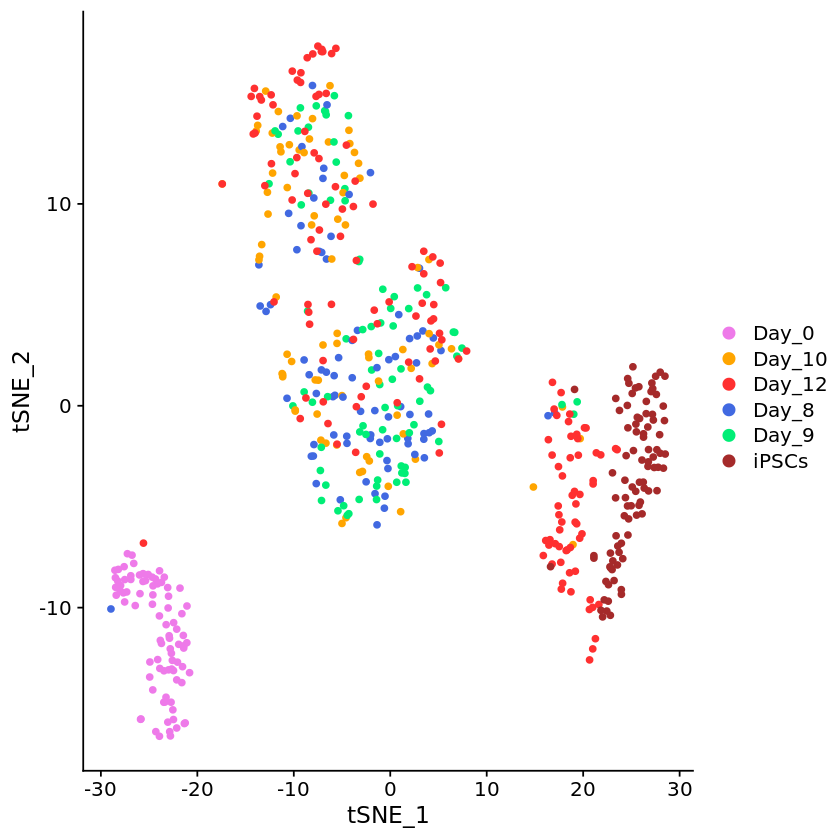

In [50]:
# note that you can set `label = TRUE` or use the LabelClusters function to help label
# individual clusters
DimPlot(seurat, reduction = "tsne", group.by = "Timepoint", pt.size = 1.5)+
scale_colour_manual(values = c("orchid2","orange","firebrick1","royalblue","springgreen2","brown"))

In [51]:
pdf("SCENIC/scenic_based_tsne.pdf", useDingbats = FALSE)
DimPlot(seurat, reduction = "tsne", group.by = "Timepoint", pt.size = 1.5) + scale_colour_manual(values = c("orchid2","orange","firebrick1","royalblue","springgreen2","brown"))
dev.off()

png 
  2

### Add the information about clusters, those defined based on gene expression before and now identify the regulons that are differentially active between those clusters

In [53]:
seurat@meta.data$clusters <- clusters$clusters

In [54]:
head(seurat@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,Timepoint,Xi,Cell,GC_index1_index2,Name,clusters
Day_9_Xi_Mus_33,Day,15.91235,179,Day_9,Mus,33,GC071392_ACTCTAGG-AAGAGGCA,Day_9_Xi_Mus_33,1
Day_10_Xi_Mus_25,Day,14.82873,180,Day_10,Mus,25,GC071392_ACTCTAGG-ACTCGCTA,Day_10_Xi_Mus_25,2
Day_10_Xi_Mus_32,Day,15.37846,182,Day_10,Mus,32,GC071392_ACTCTAGG-ACTGAGCG,Day_10_Xi_Mus_32,2
Day_9_Xi_Mus_27,Day,15.66439,182,Day_9,Mus,27,GC071392_ACTCTAGG-AGGCAGAA,Day_9_Xi_Mus_27,1
Day_9_Xi_Mus_36,Day,14.84700,184,Day_9,Mus,36,GC071392_ACTCTAGG-ATCTCAGG,Day_9_Xi_Mus_36,2
Day_10_Xi_Mus_30,Day,11.31520,160,Day_10,Mus,30,GC071392_ACTCTAGG-ATGCGCAG,Day_10_Xi_Mus_30,4


Now I can color the tsne generated based on regulons with clusters. To see how regulons cluster relative to the clusters based on gene expression

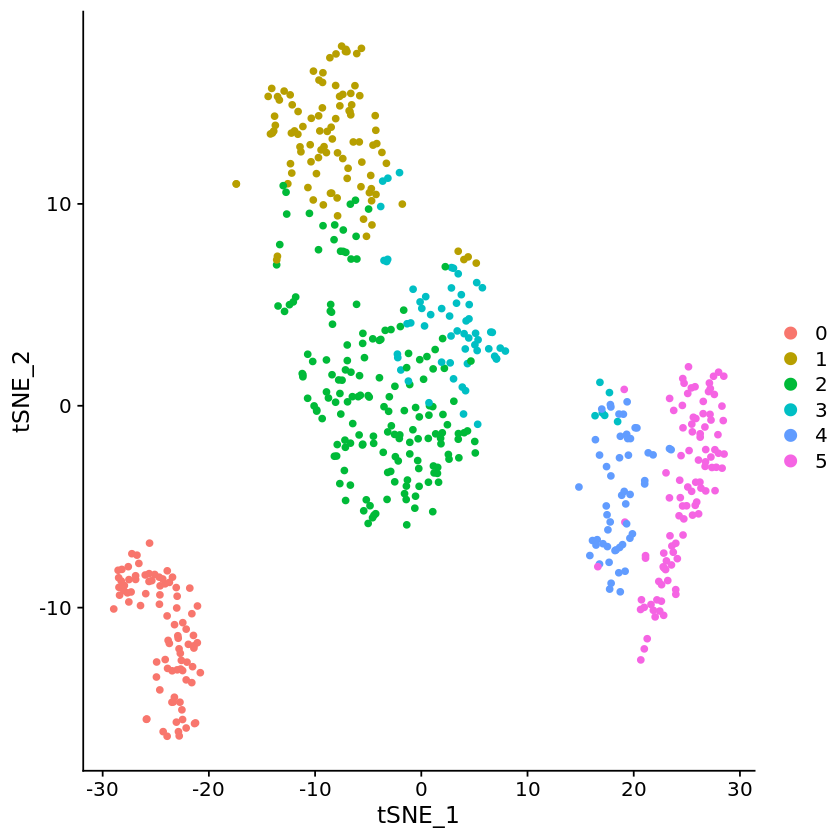

In [55]:
DimPlot(seurat, reduction = "tsne", group.by = "clusters", pt.size = 1.5)

In [56]:
pdf("SCENIC/scenic_based_tsne_col_clusters.pdf", useDingbats = FALSE)
DimPlot(seurat, reduction = "tsne", group.by = "clusters", pt.size = 1.5)
dev.off()

png 
  2

Interestingly, although clustering based on regulons puts clusters 1,2 and 3 together in one big cluster, you can still see that those three clusters are still clearly confined. And cluster 3 is still closest to cluster 4, further suggesting those cells are on the way to reprogramm

Let's see if there are any regulons that can differentiate those clusters

### Find marker regulons for each cluster

In [57]:
head(Idents(seurat), 5)

Day_9_Xi_Mus_33 Day_10_Xi_Mus_25 Day_10_Xi_Mus_32  Day_9_Xi_Mus_27 
             Day              Day              Day              Day 
 Day_9_Xi_Mus_36 
             Day 
Levels: Day iPSCs

In [58]:
Idents(object = seurat) <- "clusters"

In [59]:
levels(seurat) <- c('0','1','2','3','4','5')

In [60]:
seurat

An object of class Seurat 
311 features across 567 samples within 1 assay 
Active assay: RNA (311 features)
 2 dimensional reductions calculated: pca, tsne

In [62]:
seurat.markers <- FindAllMarkers(seurat, only.pos = TRUE, logfc.threshold = log(1))

Calculating cluster 0
Calculating cluster 1
Calculating cluster 2
Calculating cluster 3
Calculating cluster 4
Calculating cluster 5


In [64]:
head(seurat.markers %>% dplyr::filter(cluster == 3 ), n = 20)

p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
6.994729e-09,0.029723261,1.000,1.000,2.175361e-06,3,Sap30
5.746890e-08,0.024034518,1.000,1.000,1.787283e-05,3,Etv5
7.323210e-07,0.028521696,1.000,1.000,2.277518e-04,3,Brca1
8.225394e-07,0.051864495,1.000,1.000,2.558097e-04,3,Egr1
1.355194e-06,0.045267745,0.984,0.992,4.214653e-04,3,Rad21
1.426385e-06,0.021647797,0.953,0.672,4.436056e-04,3,E2f7
2.564647e-06,0.021484910,0.844,0.493,7.976052e-04,3,Etv4
7.176051e-06,0.026976395,1.000,1.000,2.231752e-03,3,Ezh2
1.766063e-05,0.023675237,0.688,0.453,5.492456e-03,3,Zfp667
2.200809e-05,0.056827678,1.000,0.928,6.844515e-03,3,Tbp


Warning message in FetchData(object = object, vars = features, slot = slot):
"The following requested variables were not found: Mybl2, Dnmt3a"

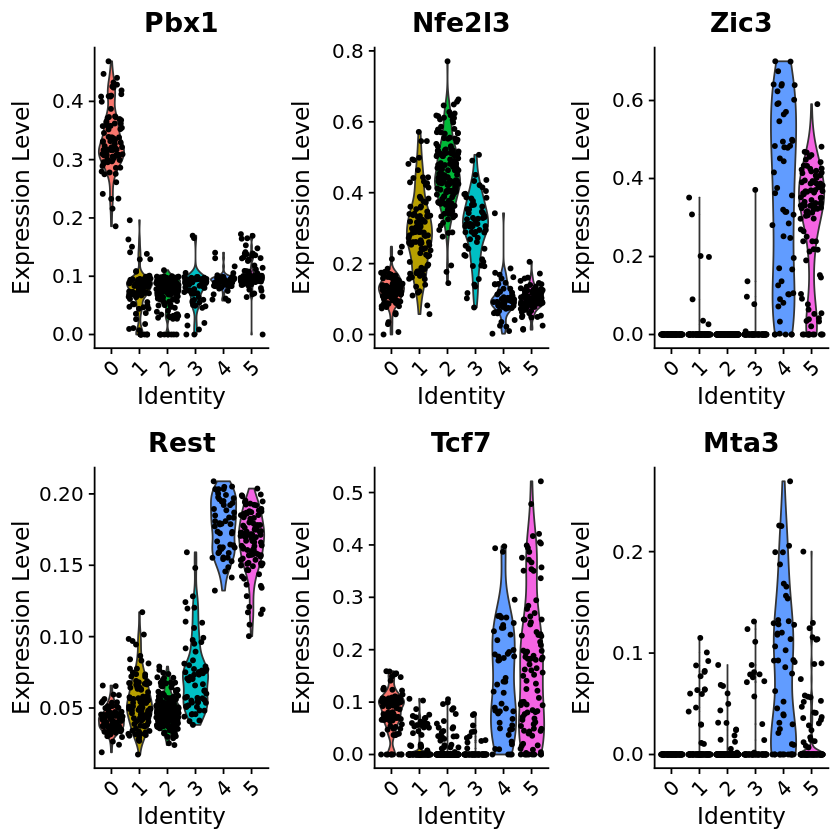

In [65]:
VlnPlot(seurat, features = c("Pbx1", "Nfe2l3","Mybl2","Zic3","Rest","Tcf7","Mta3","Dnmt3a"))

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


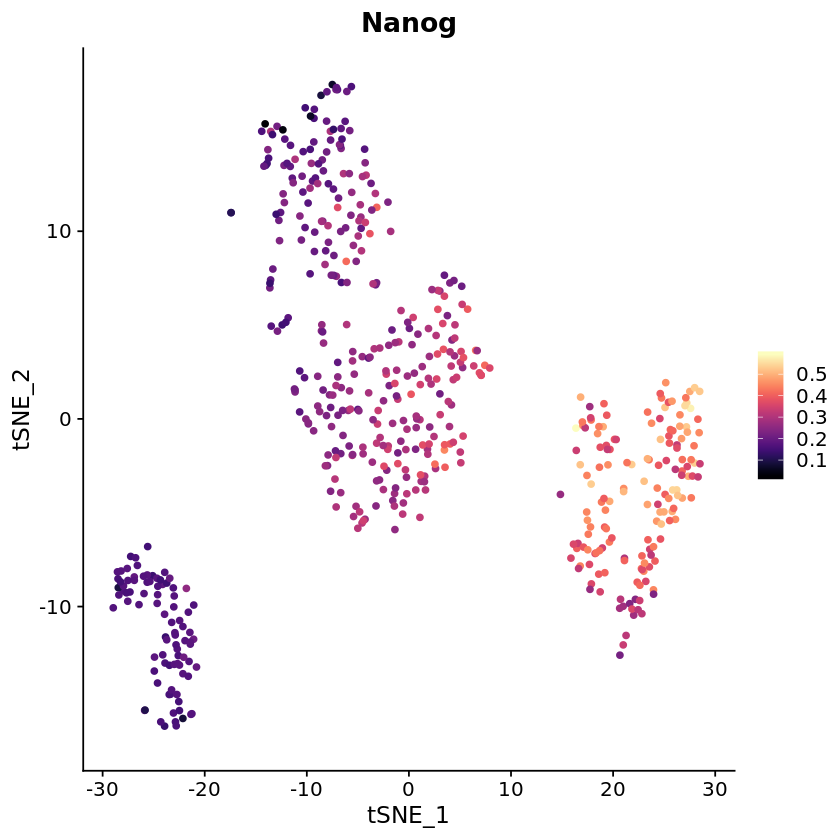

In [66]:
FeaturePlot(seurat, features = c("Nanog"), pt.size = 1.5) +
scale_color_viridis(option = "A")

In [67]:
pdf("SCENIC/scenic_based_tsne_Nanog.pdf", useDingbats = FALSE)
FeaturePlot(seurat, features = c("Nanog"), pt.size = 1.5) + scale_color_viridis(option = "A")
dev.off()

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


png 
  2

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.


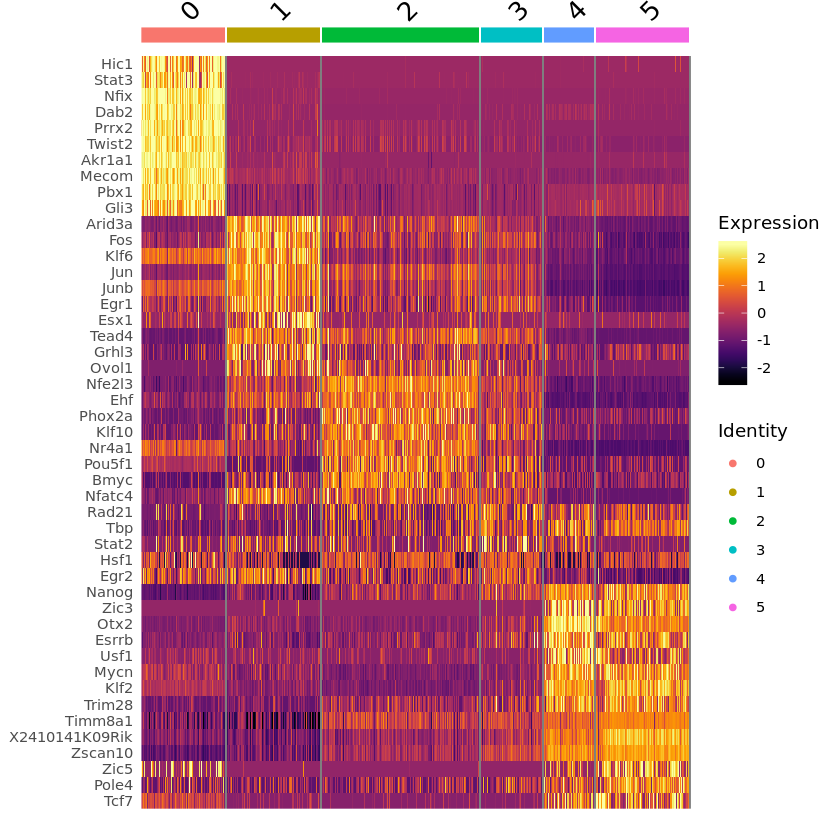

In [68]:
top10 <- seurat.markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_logFC)
DoHeatmap(seurat, features = top10$gene) + scale_fill_viridis(option = 'B')
#+ NoLegend()

In [69]:
pdf("SCENIC/311_Regulons_clustered_top10.pdf", useDingbats = FALSE)
plot(DoHeatmap(seurat, features = top10$gene) + scale_fill_viridis(option = 'B'))
dev.off()

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.


png 
  2

### Heatmap with regulons oredered by clusters and pseuodotime

Import pseuodotime values

In [70]:
pseudotime_rds <- readRDS("monocle/seurat_pseudotime.rds")

In [84]:
regulon_anno_pseudo <- pseudotime_rds@meta.data %>% 
                        as.data.frame() %>%
                        select(Name, Pseudotime) %>%
                        rename("Name" = "Cell") %>% 
                        right_join(regulon_anno, by = "Cell") 

Warning message:
"Column `Cell` joining character vector and factor, coercing into character vector"

In [85]:
head(regulon_anno_pseudo)

Cell,Pseudotime,X2410141K09Rik...,Akr1a1...,Alx1...,Alx3...,Alx4...,Arid3a...,Arnt...,Atf3...,...,Zfp467...,Zfp667...,Zic3...,Zic5...,Zmiz1...,Zscan10...,tSNE_1,tSNE_2,Timepoint,clusters
Day_9_Xi_Mus_33,32.58138,0.04189857,0.1412515,0,0,0,0.17659295,0.00000000,0.07668644,...,0.07630722,0.04782211,0.0000000,0,0.075012198,0.08569761,-9.225725,-7.4343086,Day_9,1
Day_10_Xi_Mus_25,46.77720,0.17300972,0.1295921,0,0,0,0.05630640,0.08029930,0.02993759,...,0.00000000,0.11238005,0.0000000,0,0.007973111,0.15575260,-9.906587,7.9507435,Day_10,2
Day_10_Xi_Mus_32,44.10808,0.10660650,0.1295921,0,0,0,0.10619694,0.06599512,0.05396919,...,0.00000000,0.12837342,0.0000000,0,0.031736208,0.12836103,-10.664682,0.2424442,Day_10,2
Day_9_Xi_Mus_27,43.73724,0.11266982,0.1293932,0,0,0,0.13793736,0.03021848,0.07551412,...,0.00000000,0.03700477,0.0000000,0,0.039008209,0.11342516,-9.670420,-5.1948308,Day_9,1
Day_9_Xi_Mus_36,31.37012,0.13542941,0.1290948,0,0,0,0.11177643,0.00000000,0.04981346,...,0.07376799,0.06449128,0.0000000,0,0.023464786,0.16054179,-8.247826,-0.1422239,Day_9,2
Day_10_Xi_Mus_30,71.55450,0.24870989,0.1293932,0,0,0,0.02614772,0.00000000,0.03021372,...,0.05202173,0.08431324,0.1364037,0,0.009582028,0.21361607,8.634478,7.8346926,Day_10,4


In [86]:
regulon_heatmap <- regulon_anno_pseudo %>%
                            select(-c(Timepoint, tSNE_1, tSNE_2))

In [87]:
colnames(regulon_heatmap) <- gsub('\\...', '', colnames(regulon_heatmap)) # Remove 3 dots at the end of regulon's name
head(regulon_heatmap)

Cell,Pseudotime,X2410141K09Rik,Akr1a1,Alx1,Alx3,Alx4,Arid3a,Arnt,Atf3,...,Zfp362,Zfp410,Zfp42,Zfp467,Zfp667,Zic3,Zic5,Zmiz1,Zscan10,clusters
Day_9_Xi_Mus_33,32.58138,0.04189857,0.1412515,0,0,0,0.17659295,0.00000000,0.07668644,...,0,0.0000000,0.06540736,0.07630722,0.04782211,0.0000000,0,0.075012198,0.08569761,1
Day_10_Xi_Mus_25,46.77720,0.17300972,0.1295921,0,0,0,0.05630640,0.08029930,0.02993759,...,0,0.0000000,0.11827622,0.00000000,0.11238005,0.0000000,0,0.007973111,0.15575260,2
Day_10_Xi_Mus_32,44.10808,0.10660650,0.1295921,0,0,0,0.10619694,0.06599512,0.05396919,...,0,0.0000000,0.08585769,0.00000000,0.12837342,0.0000000,0,0.031736208,0.12836103,2
Day_9_Xi_Mus_27,43.73724,0.11266982,0.1293932,0,0,0,0.13793736,0.03021848,0.07551412,...,0,0.0000000,0.09190361,0.00000000,0.03700477,0.0000000,0,0.039008209,0.11342516,1
Day_9_Xi_Mus_36,31.37012,0.13542941,0.1290948,0,0,0,0.11177643,0.00000000,0.04981346,...,0,0.1712373,0.08658987,0.07376799,0.06449128,0.0000000,0,0.023464786,0.16054179,2
Day_10_Xi_Mus_30,71.55450,0.24870989,0.1293932,0,0,0,0.02614772,0.00000000,0.03021372,...,0,0.0000000,0.18275565,0.05202173,0.08431324,0.1364037,0,0.009582028,0.21361607,4


In [88]:
# Create a matrix that will be used to 1) select top variable regulons 2) cluster regulons based on similarity
regulon_heatmap.matrix <- as.matrix(select(regulon_heatmap, -c(Cell, clusters, Pseudotime)))
regulon_heatmap.matrix <- t(regulon_heatmap.matrix)
head(regulon_heatmap.matrix)

X2410141K09Rik,0.04189857,0.1730097,0.1066065,0.1126698,0.1354294,0.24870989,0.1104708,0.1376676,0.1405198,0.207175768,...,0.30183685,0.20605619,0.27255571,0.313626873,0.311225269,0.253466862,0.305373230,0.3066469,0.26952744,0.30643780
Akr1a1,0.14125150,0.1295921,0.1295921,0.1293932,0.1290948,0.12939318,0.1277024,0.2502450,0.1335637,0.128995349,...,0.12909481,0.12969155,0.12889589,0.128895892,0.128895892,0.177322419,0.129492632,0.1289953,0.12909481,0.12929372
Alx1,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,0.00000000,0.0000000,0.0000000,0.0000000,0.000000000,...,0.00000000,0.05865873,0.00000000,0.000000000,0.000000000,0.000000000,0.000000000,0.0000000,0.00000000,0.00000000
Alx3,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,0.00000000,0.0000000,0.0000000,0.0000000,0.005523436,...,0.00000000,0.00000000,0.00000000,0.000000000,0.000000000,0.000000000,0.000000000,0.0000000,0.00000000,0.00000000
Alx4,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,0.00000000,0.0000000,0.0000000,0.0000000,0.000000000,...,0.00000000,0.00000000,0.00738797,0.000000000,0.000000000,0.000000000,0.000000000,0.0000000,0.00000000,0.00000000
Arid3a,0.17659295,0.0563064,0.1061969,0.1379374,0.1117764,0.02614772,0.1426922,0.1623219,0.1668901,0.110459134,...,0.01108922,0.01642074,0.01264046,0.003818799,0.006898768,0.009666428,0.009332876,0.0065530,0.00422476,0.00896908


In [89]:
topVarRegulons <- head(order(rowVars(regulon_heatmap.matrix),decreasing=TRUE), 150 )
topVarRegulons_names <- rownames(regulon_heatmap.matrix)[topVarRegulons] # This will be used to later subset the plotted df

In [90]:
# Keep only the variable regulons for clustering
regulon_heatmap.matrix <- regulon_heatmap.matrix[topVarRegulons,]

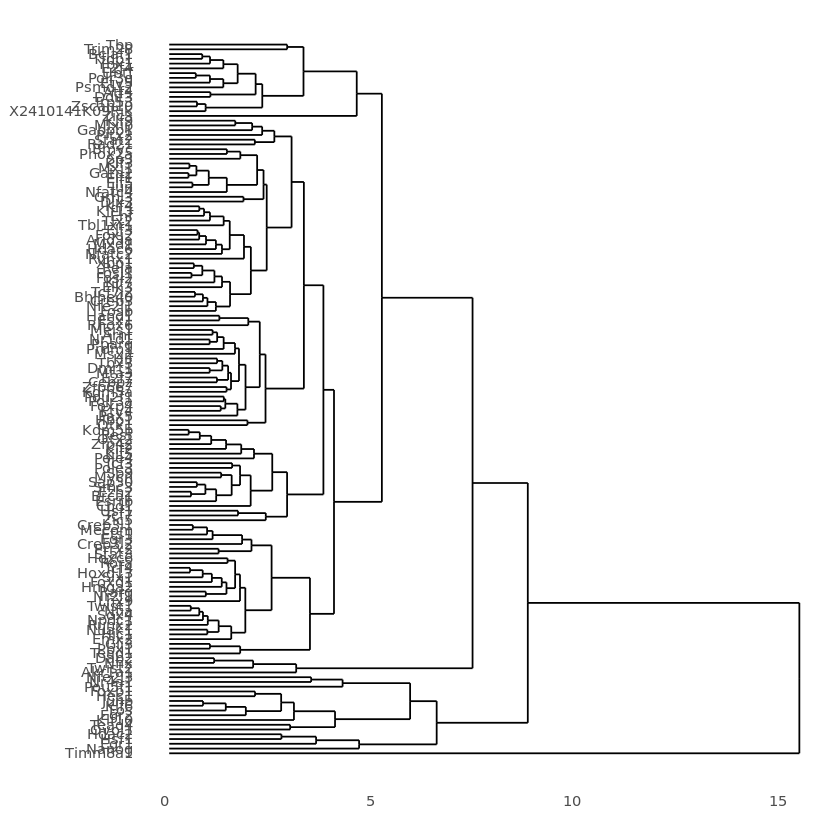

In [91]:
# Run clustering
regulon.dendro <- as.dendrogram(hclust(d = dist(x = regulon_heatmap.matrix)))

# Create dendro
regulon.plot <- ggdendrogram(data = regulon.dendro, rotate = TRUE)

# Preview the plot
print(regulon.plot)

In [92]:
regulon.order <- order.dendrogram(regulon.dendro)

In [93]:
# Store regulons in a vector in the order based on clustering, to be used later to level the factor
regulon.order <- rownames(regulon_heatmap.matrix)[regulon.order]

In [119]:
head(regulon.order)

[1] "Timm8a1" "Nanog"   "Egr1"    "Hsf1"    "Hdac2"   "Ovol1"

In [95]:
write.csv(regulon.order, file = "SCENIC/top150_variable_regulons.csv")

In [96]:
regulon_heatmap <- regulon_heatmap %>%
                            gather(regulon, activity, -Cell, -clusters, -Pseudotime) %>%
                            dplyr::filter(regulon %in% topVarRegulons_names)

In [97]:
regulon_heatmap$regulon <- factor(regulon_heatmap$regulon,
                               levels = regulon.order, 
                               ordered = TRUE)

In [98]:
head(regulon_heatmap)

Cell,Pseudotime,clusters,regulon,activity
Day_9_Xi_Mus_33,32.58138,1,X2410141K09Rik,0.04189857
Day_10_Xi_Mus_25,46.77720,2,X2410141K09Rik,0.17300972
Day_10_Xi_Mus_32,44.10808,2,X2410141K09Rik,0.10660650
Day_9_Xi_Mus_27,43.73724,1,X2410141K09Rik,0.11266982
Day_9_Xi_Mus_36,31.37012,2,X2410141K09Rik,0.13542941
Day_10_Xi_Mus_30,71.55450,4,X2410141K09Rik,0.24870989


Load in function that orders within facets by Robs

In [99]:
reorder_within <- function(x, by, within, fun = mean, sep = "___", ...) {
  new_x <- paste(x, within, sep = sep)
  stats::reorder(new_x, by, FUN = fun)
}


#' @rdname reorder_within
#' @export
scale_x_reordered <- function(..., sep = "___") {
  reg <- paste0(sep, ".+$")
  ggplot2::scale_x_discrete(labels = function(x) gsub(reg, "", x), ...)
}


#' @rdname reorder_within
#' @export
scale_y_reordered <- function(..., sep = "___") {
  reg <- paste0(sep, ".+$")
  ggplot2::scale_y_discrete(labels = function(x) gsub(reg, "", x), ...)
}

In [100]:
regulon_heatmap <- regulon_heatmap %>% dplyr::mutate(Cell = as.factor(Cell),
           Cell = reorder_within(Cell, (Pseudotime)*-1, clusters)) 

#%>%
#            mutate(regulon = factor(.$regulon, levels = gene_signatures))

In [101]:
head(regulon_heatmap)

Cell,Pseudotime,clusters,regulon,activity
Day_9_Xi_Mus_33___1,32.58138,1,X2410141K09Rik,0.04189857
Day_10_Xi_Mus_25___2,46.77720,2,X2410141K09Rik,0.17300972
Day_10_Xi_Mus_32___2,44.10808,2,X2410141K09Rik,0.10660650
Day_9_Xi_Mus_27___1,43.73724,1,X2410141K09Rik,0.11266982
Day_9_Xi_Mus_36___2,31.37012,2,X2410141K09Rik,0.13542941
Day_10_Xi_Mus_30___4,71.55450,4,X2410141K09Rik,0.24870989


In [102]:
options(repr.plot.width=7, repr.plot.height=7)

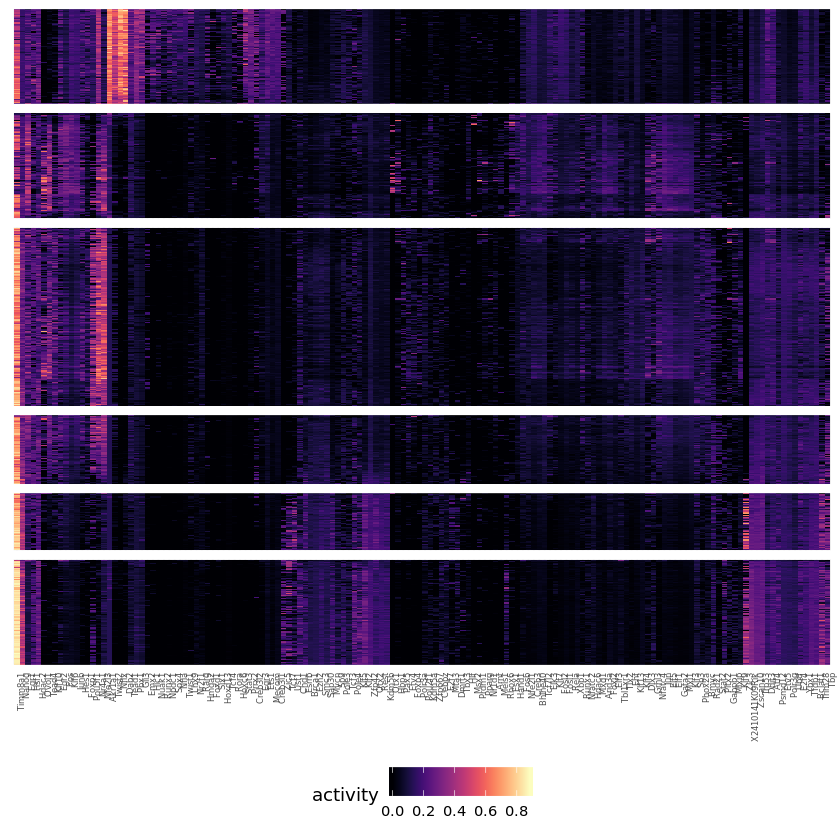

In [103]:
hm <- ggplot(regulon_heatmap, aes(x=regulon,y=Cell, fill = activity))+
        geom_tile()+
        scale_fill_viridis(option = 'A')+
        scale_y_reordered() +
        facet_grid(clusters ~ ., scales = 'free', space = 'free_y') +
        theme_minimal() +
        theme(legend.position = "bottom") +
        theme(axis.text.y=element_blank()) +
        theme(strip.background = element_blank(),
          strip.text.y = element_blank()) +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, size =5)) +
        theme(axis.title.x = element_blank()) +
        theme(axis.title.y = element_blank())
hm

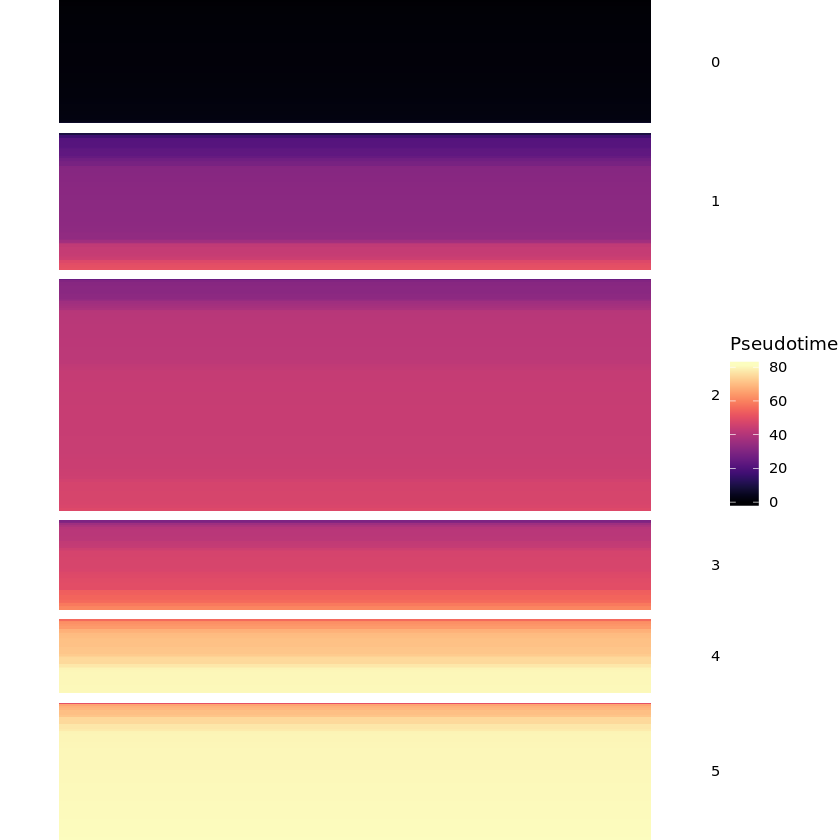

In [104]:
pt <- ggplot(regulon_heatmap, aes(x='pseudotime',y=Cell, fill = Pseudotime))+
        geom_tile()+
        scale_fill_viridis(option = 'A')+
        scale_y_reordered()+
        facet_grid(clusters ~ ., scales = 'free', space = 'free_y') +
        theme_void() +
        theme(legend.position = "right")+
        theme(axis.text.y=element_blank()) +
        theme(strip.background = element_blank(),
          strip.text.x = element_blank())
pt

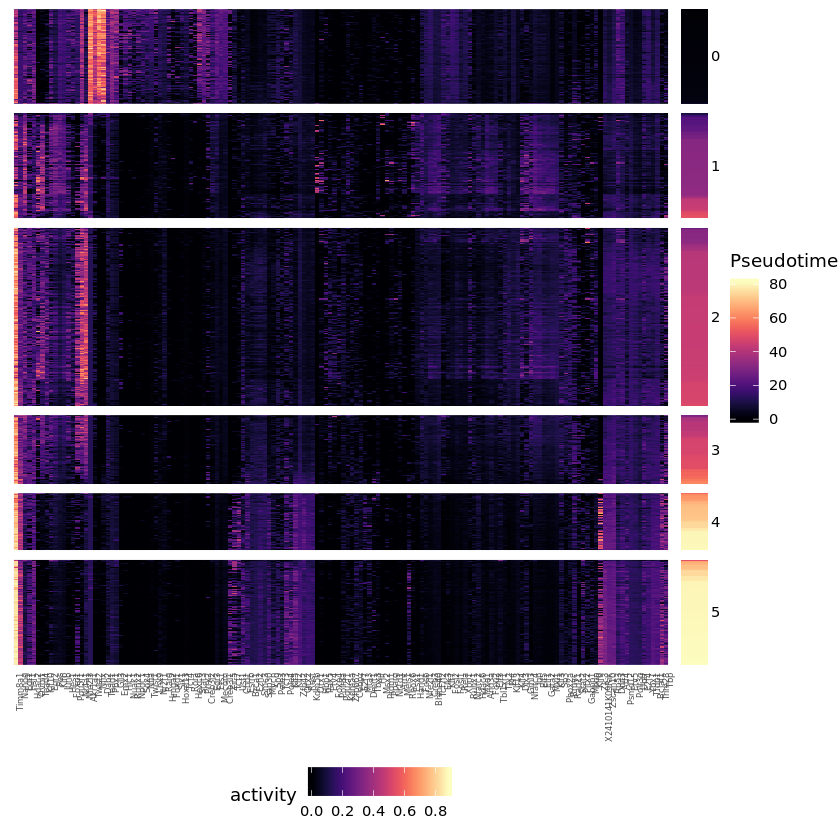

In [105]:
top150VarReg <- ggarrange(
                          hm, pt, 
                          nrow = 1, ncol = 2, widths = c(20,1)
                        )

In [106]:
pdf("SCENIC/top150VarReg_heatmap.pdf", useDingbats = FALSE)
plot(top150VarReg)
dev.off()

png 
  2